In [810]:
import os, scipy, sklearn, spacy, glob, joblib
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from helpers import *
import html2text
import markdown
from bs4 import BeautifulSoup
from scipy.spatial.distance import cdist, pdist, squareform
import nltk
# nltk.download('stopwords')
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords as sw

%matplotlib inline

In [770]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = '../data'
fname = os.path.join(datadir, 'data_wiped_scripts.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [771]:
data = pd.read_csv(fname, index_col=0)
data.dropna(inplace=True)

In [772]:
data.head()

,id,title,url,writers,genres,script,Action,Adventure,Animation,Biography,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,wiped_scripts
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,True,False,False,False,False,False,False,ten things i hate about you by karen mccullah ...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve script
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve and holding written by anthony s cipria...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,False,True,False,False,True,False,False,twelve monkeys twelve monkeys an original scre...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve years a slave written by john ridley ca...


In [773]:
genres = list(data.columns[6:-2])
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War']

In [774]:
print(len(data))

1110


## Clean scripts (the results of this have been stored in data_wiped_scripts.csv)

In [685]:
# a = [data['genres'].values[i].split(';') for i in range(len(data))]
# a
# genres = []
# for i in a:
#     for j in i:
#         if len(j) > 1:
#             for k in j.split('.'):
#                 genres.append(k.strip())
# genres = np.unique(np.array(genres))
# #genres = pd.DataFrame({'genre':genres}).drop_duplicates().sort_values(by='genre').reset_index(drop=True)
# genres

In [8]:
# for g in genres:
#     data[g] = data['genres'].apply(lambda x: g in x)

In [9]:
# data.dropna(inplace=True)

In [10]:
# data['wiped_scripts'] = data['script'].apply(lambda x: cleanup_text(wipe_formatting(x)))

In [11]:
# data.head()

In [12]:
# data.to_csv('../data/data_wiped_scripts.csv')

## Run topic model

In [1054]:
# Load character names to exclude
char_names = pd.read_csv('../data/act_to_char.csv',index_col=0)
char_names.head()
chars = char_names['char'].tolist()
chars = [chars[i].split(sep=' ') for i in range(len(chars))]
chars_full = []
for char in chars:
    for char_bit in char:
        chars_full.append(''.join(filter(str.isalpha, char_bit.lower().strip())))
exclude = chars_full
for word in sw.words('english'):
    exclude.extend(str(word))
exclude = np.unique(exclude).tolist()

In [1055]:
n_topics = 150
video_wsize = 50 # sentences 
corpus = data['wiped_scripts'].values.tolist()

# vectorizer parameters
vectorizer_params = {
    'stop_words' : exclude,
    'max_df' : 0.4,
    'min_df' : 0.05
}

# topic model parameters
semantic_params = {
    'n_components' : n_topics,
    'learning_method' : 'batch',
    'random_state' : 0,
}

In [1056]:
cv = CountVectorizer(**vectorizer_params)
counts = cv.fit_transform(corpus)

##### Did it successfully exclude names?

In [1057]:
['ellis' in cv.get_feature_names(), 'mozart' in cv.get_feature_names(),
 'morpheus' in cv.get_feature_names(), 'paul' in cv.get_feature_names()]

[False, False, False, False]

##### Looks like a sparse matrix?

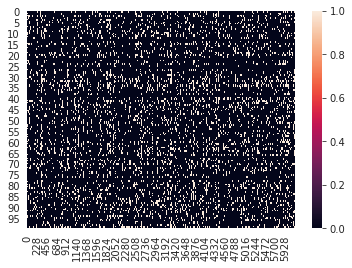

In [1058]:
%matplotlib inline
sns.heatmap(counts[:100,:].todense() > 0)

##### Run LDA

In [1059]:
lda = LatentDirichletAllocation(**semantic_params)
lda.fit(counts)
print('LDA model fitted!')

LDA model fitted!


##### Load model we used for results

In [1068]:
cv = joblib.load('../data/cv_corpus-scripts.joblib')
lda = joblib.load('../data/lda_corpus-scripts_ntopics-150.joblib')

##### Show topics

In [1069]:
weights = lda.components_.copy()
words = cv.get_feature_names()

def get_top_words(model, vocab, n_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):       
        next = topic.argsort()[:-n_words - 1:-1]
        next_words = list(map(lambda x: vocab[x], next))
        top_words.append(next_words)
        print(f'TOPIC {topic_idx}: {", ".join(next_words)}')
    return top_words

top_words = get_top_words(lda, words, 10)

TOPIC 0: joes, vo, driveway, patio, goddam, darlin, vote, students, remembered, continuous
TOPIC 1: ha, sams, continuous, ooh, whoa, workers, bye, ms, culture, crab
TOPIC 2: offscreen, overlapping, gesturing, nodding, reacting, sighing, interrupting, chuckling, continuing, guests
TOPIC 3: heh, agents, continuous, tapes, fuse, ok, fixing, dumb, whoa, dammit
TOPIC 4: typewriter, typing, types, pages, folder, tits, blah, wrote, flask, insert
TOPIC 5: branches, slope, ridge, crouches, wilderness, supplies, brush, blankets, meat, feathers
TOPIC 6: goddam, dope, angles, oclock, meat, bye, offscreen, guests, marys, motorcycles
TOPIC 7: hanger, whoa, goo, systems, maximum, punch, hack, fridge, vents, ow
TOPIC 8: buttons, oxygen, atmosphere, meters, outer, solar, static, universe, transmission, floats
TOPIC 9: ok, continuous, bye, um, pills, relationship, whoa, tshirt, cmon, awkwardly
TOPIC 10: sams, fuckin, closeup, doin, motherfucker, outta, uhhuh, fitting, monitoring, intercom
TOPIC 11: fuck

## Plot movie similarity in topic space, cluster

In [1070]:
data['topic_vector'] = data['wiped_scripts'].apply(lambda x: lda.transform(cv.transform([x]))[0])
data_sorted = data.sort_values(by = list(genres), ascending=False)
topic_vectors_sorted = np.vstack(data_sorted['topic_vector'])

<IPython.core.display.Javascript object>


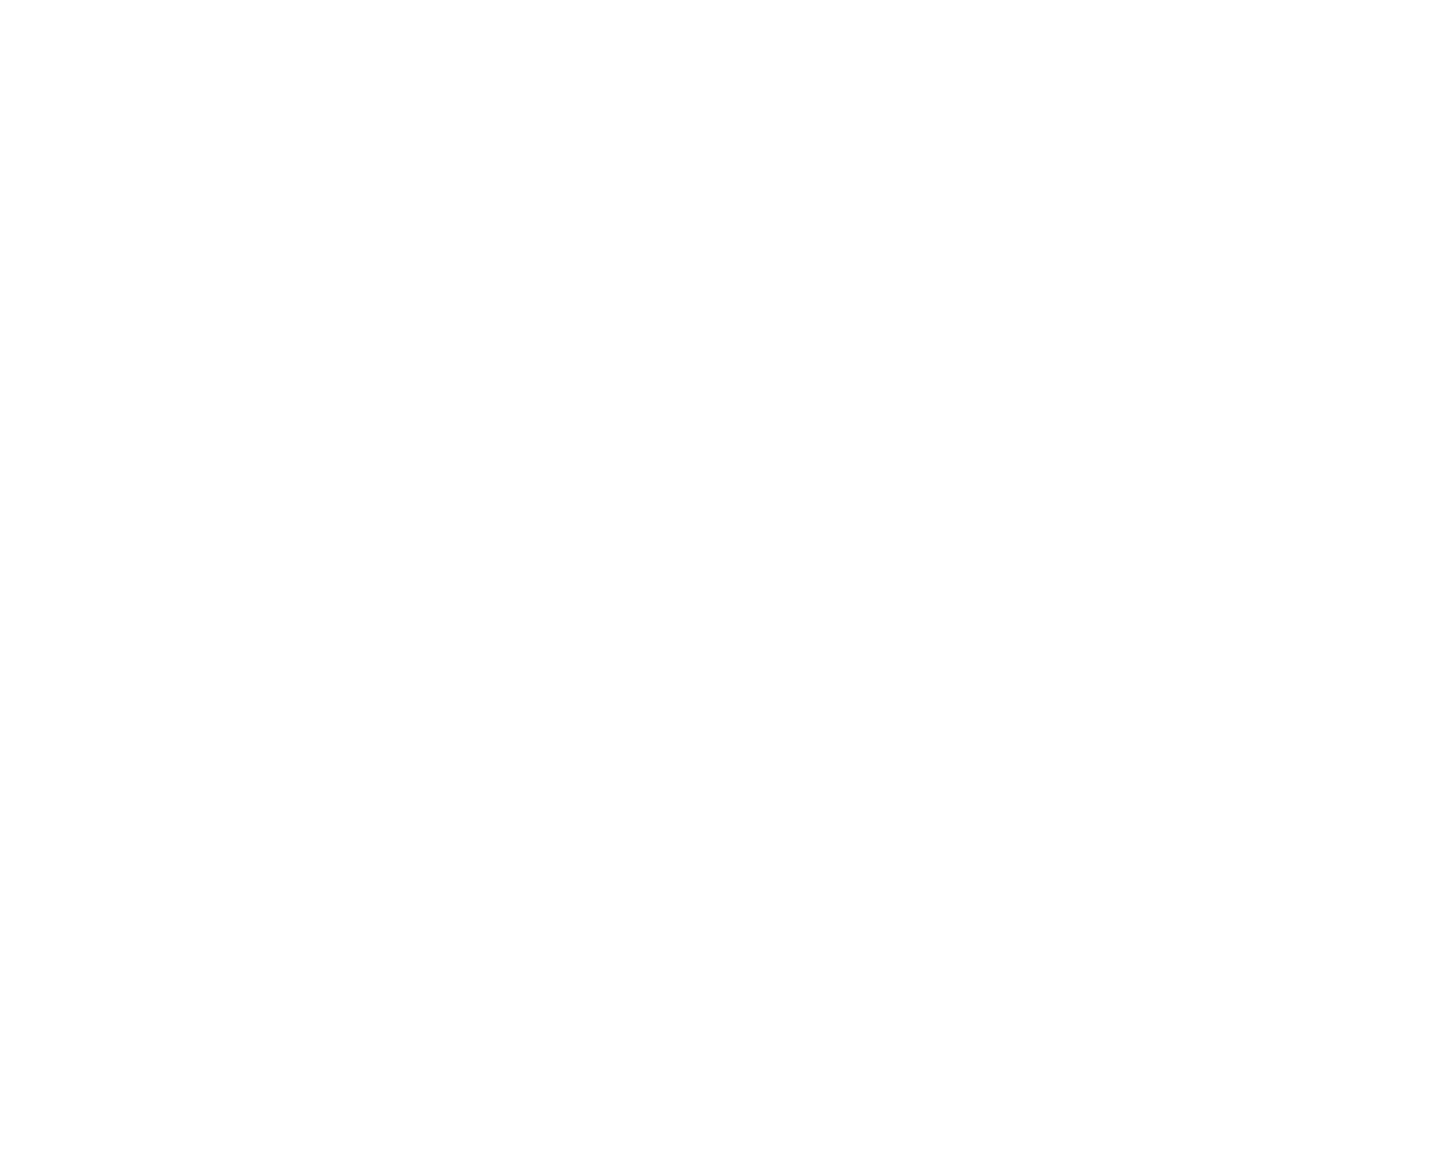

In [1071]:
fig, ax = plt.subplots(1,1,figsize=[10,8])
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(topic_vectors_sorted), ax = ax)
# plt.savefig('/mnt/Cosine_similarity.pdf',bbox_inches='tight')

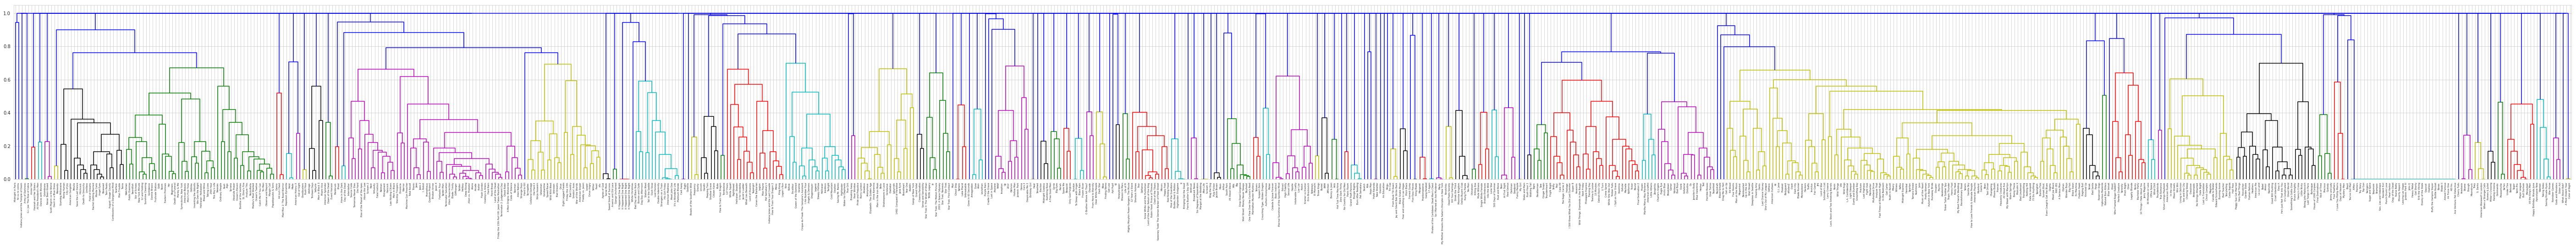

In [1072]:
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(np.vstack(data['topic_vector']), method='complete',metric='cosine')
plt.figure(figsize=(100, 7))
dendrogram(linked, labels=data['title'].values);
# plt.savefig('/mnt/Dendrogram_scripts.pdf',bbox_inches='tight')

## Plot movies in topic space

<IPython.core.display.Javascript object>


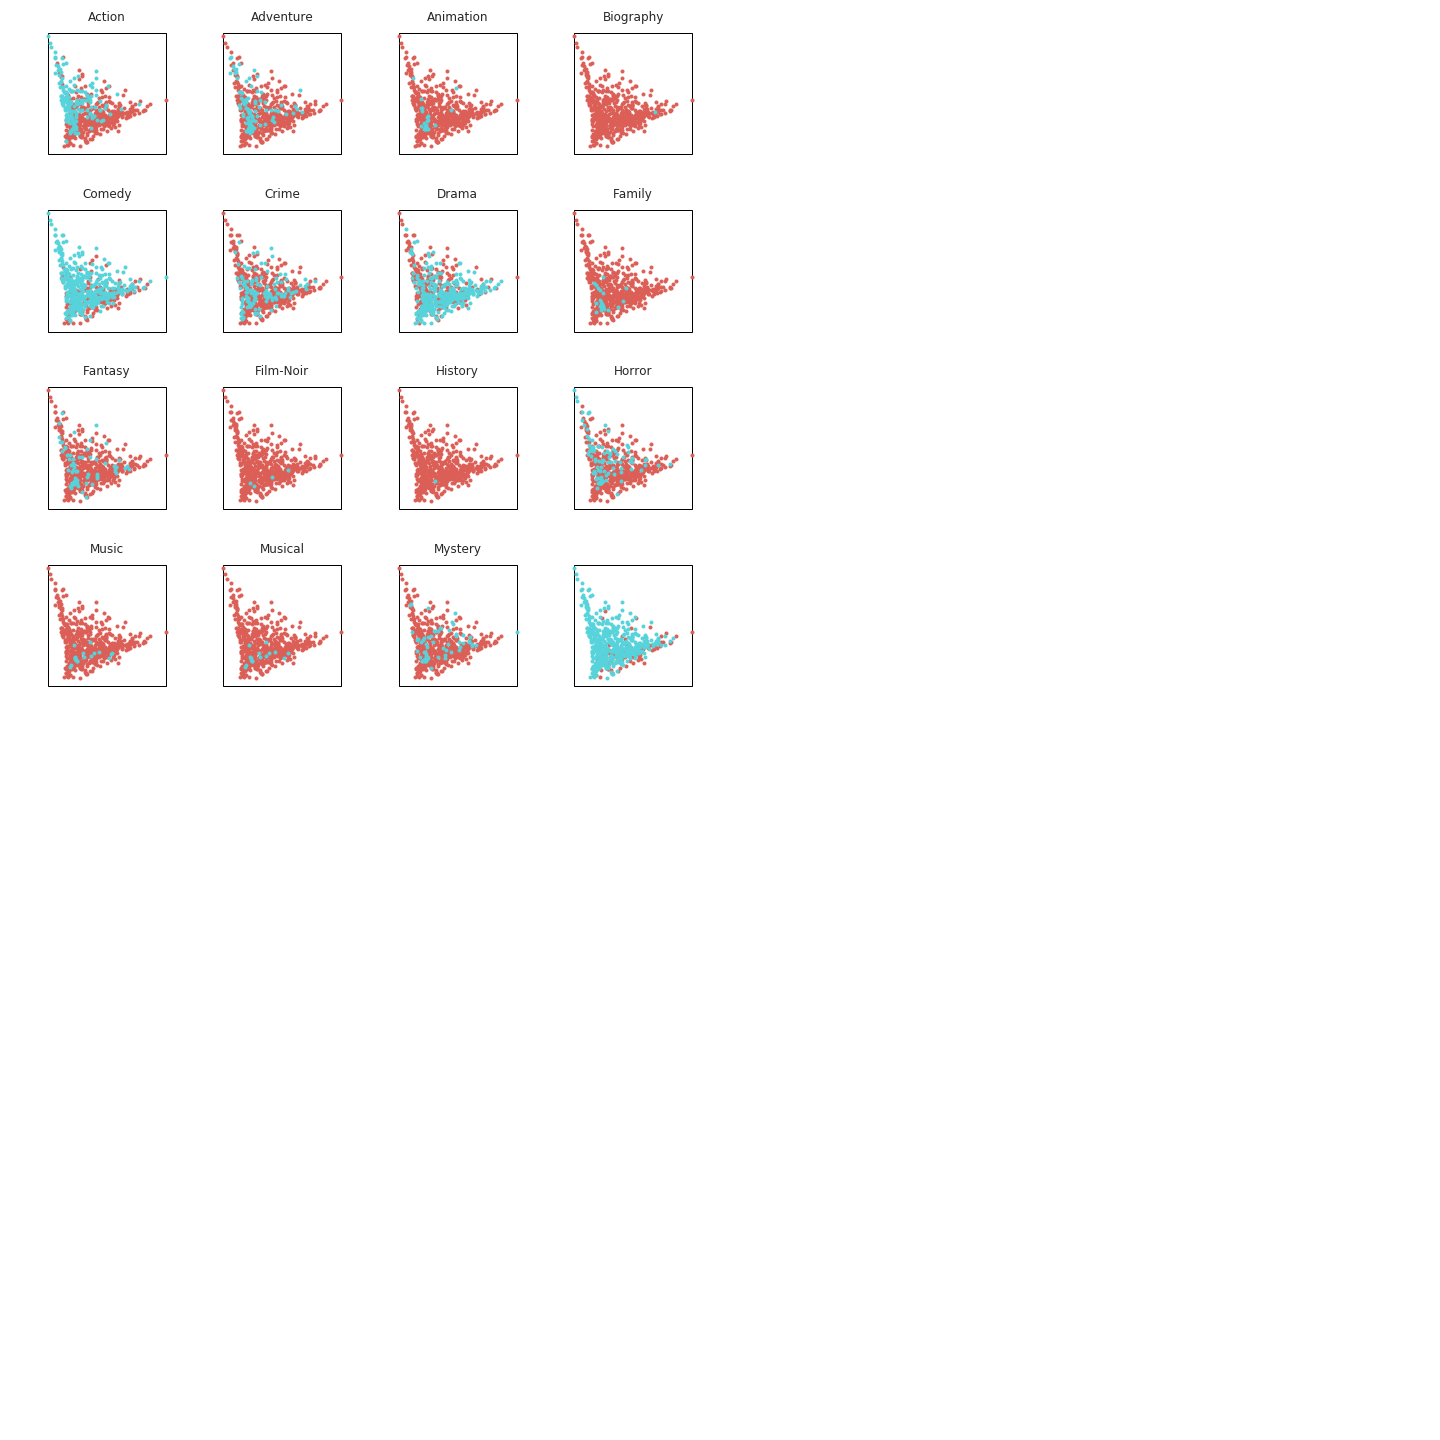

In [1073]:
%matplotlib notebook
fig, ax = plt.subplots(4,4,figsize=[10,10])
ax = ax.flatten()
for ai, ax_current in enumerate(ax):
    genre_choice = genres[ai]
    hyp.plot(np.vstack(data['topic_vector']),'.', ndims=2, ax=ax_current,
             hue = data[genre_choice], palette = 'tab10',
#              labels = data[genre_choice].unique().tolist()
            )
    ax_current.set(title = genre_choice)
plt.show()

In [1074]:
%matplotlib notebook
hyp.plot(np.vstack(data['topic_vector']),'.', ndims=3, hue = data['Action'])
plt.show()

<IPython.core.display.Javascript object>

In [1075]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state = 0)
pca_result = pca.fit_transform(np.vstack(data['topic_vector']))

<IPython.core.display.Javascript object>


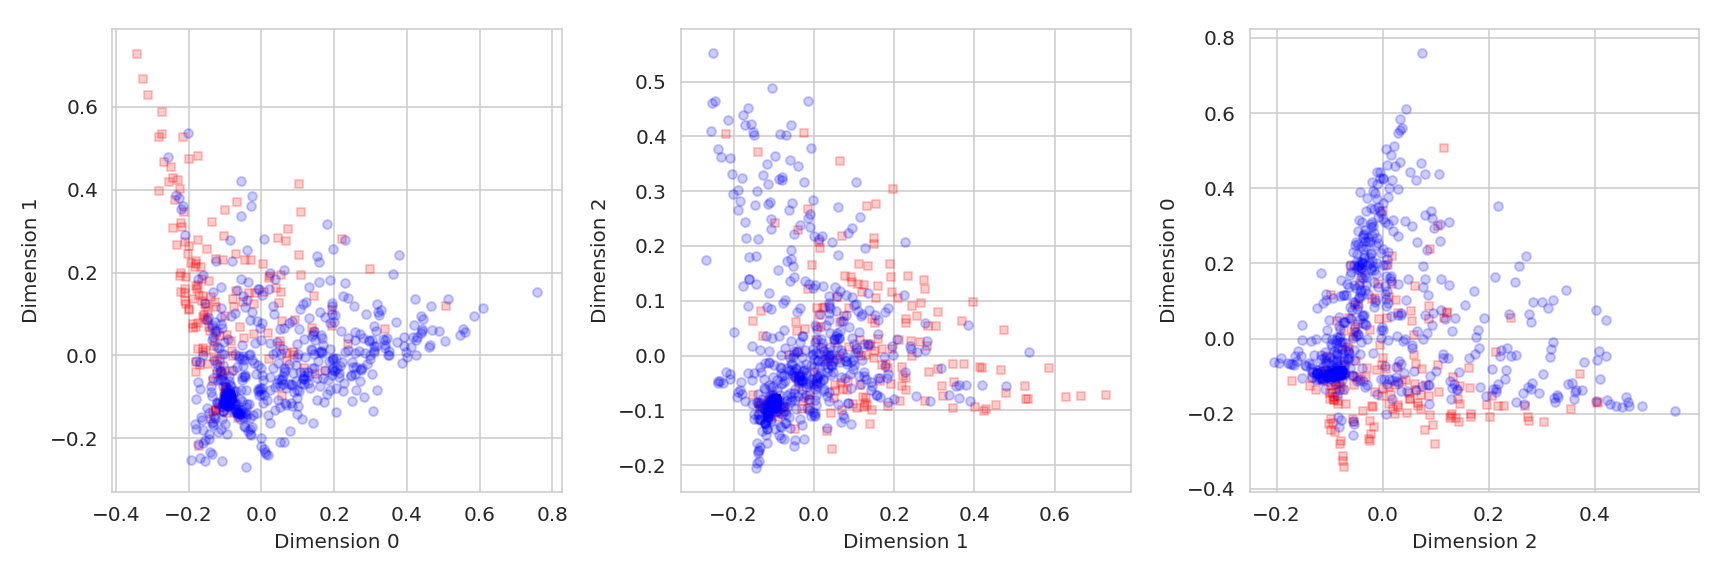

In [1076]:
fig, ax = plt.subplots(1,3, figsize=[12,4])
for dim in [0,1,2]:
    xdim = 0+dim
    ydim = np.mod(1+dim,3)
    ax[dim].scatter(pca_result[data['Action'],xdim],pca_result[data['Action'],ydim], 
                    alpha = .2, s=20, c='r', marker = 's')
    ax[dim].scatter(pca_result[~data['Action'],xdim],pca_result[~data['Action'],ydim],
                    alpha = .2, s=20, c='b', marker = 'o')
    ax[dim].set(xlabel = 'Dimension %i'%xdim, ylabel = 'Dimension %i'%ydim)
plt.tight_layout()
plt.show()

##### Cool result: top 10 words in top 1 topic in top 1 component capturing most variance in movie topic differences:

In [1077]:
for comp in [0,1,2]:
    strongest_topics = np.where(np.abs(pca.components_[comp])>0.5)[0]
    print([top_words[topic] for topic in strongest_topics])

[['pages', 'applause', 'intercut', 'driveway', 'notebook', 'considers', 'particular', 'blinks', 'pills', 'frowns']]
[['bullets', 'explosion', 'trigger', 'upward', 'lunges', 'concrete', 'rapidly', 'claws', 'vehicles', 'rushing']]
[['continued', 'continuous', 'november', 'numbered', 'driveway', 'intercut', 'cake', 'buttons', 'thirtys', 'curb']]


## Relate topics to ratings

In [782]:
rating_data = pd.read_csv('../data/data_wmetrics.csv')
data = data.merge(rating_data[['title','metascore']])
data.head()

,id,title,url,writers,genres,script,Action,Adventure,Animation,Biography,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,wiped_scripts,topic_vector,metascore
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,True,False,False,False,False,False,False,ten things i hate about you by karen mccullah ...,"[5.89448865311806e-06, 5.89448865311806e-06, 5...",70.0
1,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...,False,False,False,False,...,False,False,False,False,False,False,False,twelve and holding written by anthony s cipria...,"[0.05250211640166881, 6.666666666675797e-06, 6...",65.0
2,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...,False,False,False,False,...,False,False,False,False,False,False,False,twelve years a slave written by john ridley ca...,"[0.002355039201095223, 0.002548143817454244, 2...",96.0
3,6,127 Hours,http://www.imsdb.com/scripts/127-Hours.html,Simon Beaufoy;Danny Boyle,Adventure;Drama;Thriller,\r\n\r\n \r\n ...,False,True,False,False,...,False,False,False,False,True,False,False,one hundred and twenty-seven hours written by ...,"[4.941932295534859e-06, 4.941932295534859e-06,...",82.0
4,7,1492: Conquest of Paradise,http://www.imsdb.com/scripts/1492-Conquest-of-...,Roslyne Bosch,Adventure;Drama,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,True,False,False,...,False,False,False,False,False,False,False,one thousand four hundred and ninety-two conqu...,"[4.042854255109809e-06, 4.042854255109809e-06,...",47.0


<IPython.core.display.Javascript object>


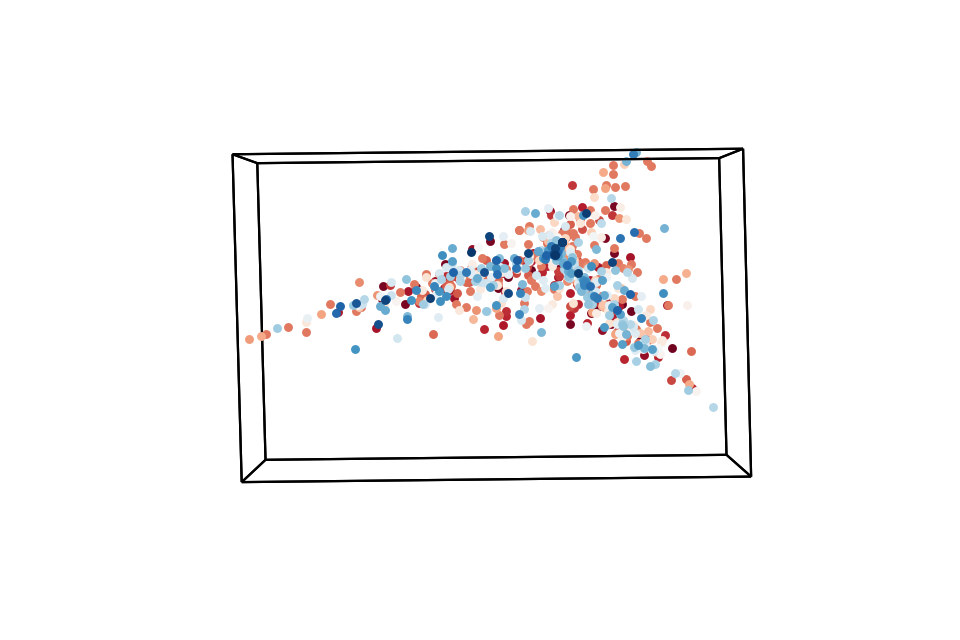

In [785]:
%matplotlib notebook
hyp.plot(np.vstack(data['topic_vector']),'.', ndims=3, hue = data['metascore'], palette = 'RdBu')
plt.show()

In [796]:
plot_dat = data.dropna().copy().reset_index(drop=True)

In [797]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state = 0)
pca_result = pca.fit_transform(np.vstack(plot_dat['topic_vector']))

In [798]:
colors = sns.color_palette('RdBu',101)
colors[99]

(0.04113802383698577, 0.22975778546712802, 0.4380622837370242)

<IPython.core.display.Javascript object>


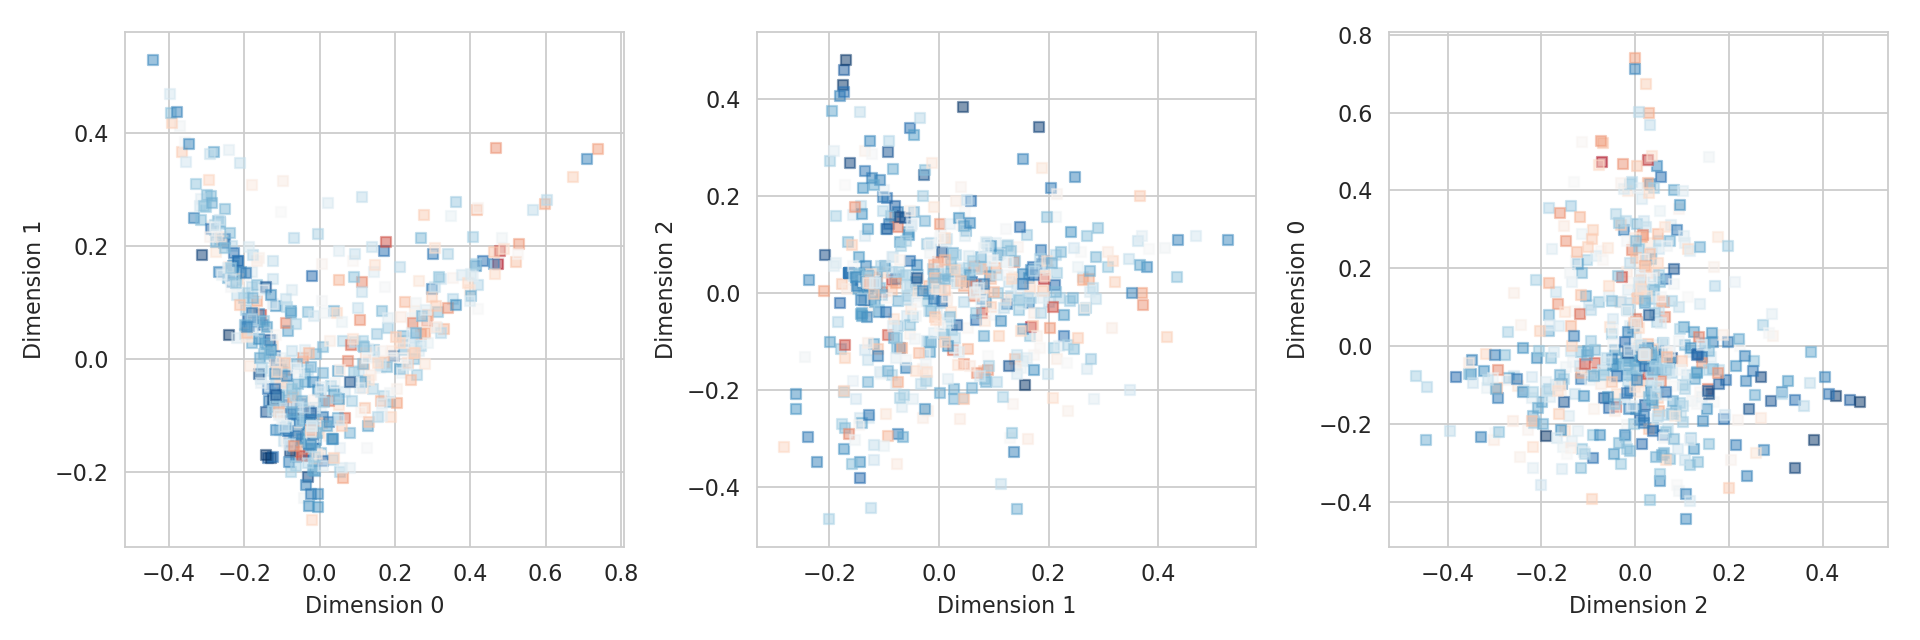

In [800]:
fig, ax = plt.subplots(1,3, figsize=[12,4])
for dim in [0,1,2]:
    xdim = 0+dim
    ydim = np.mod(1+dim,3)
    for di, data_row in plot_dat.iterrows():
        ax[dim].scatter(pca_result[di,xdim],pca_result[di,ydim], 
                    alpha = .5, s=20, c=colors[int(np.round(data_row['metascore']))], marker = 's')
#     ax[dim].scatter(pca_result[~data['Action'],xdim],pca_result[~data['Action'],ydim],
#                     alpha = .2, s=20, c='b', marker = 'o')
    ax[dim].set(xlabel = 'Dimension %i'%xdim, ylabel = 'Dimension %i'%ydim)
plt.tight_layout()
plt.show()

## Cluster genres based on similarity

In [93]:
genre_topic_vectors = pd.DataFrame()
for genre in genres:
    mean_genre_topic_vector = np.mean(np.vstack(data.loc[data[genre],'topic_vector']), axis = 0)
#     mean_genre_topic_vector.shape
    genre_topic_vectors[genre] = mean_genre_topic_vector
genre_topic_vectors = genre_topic_vectors.T

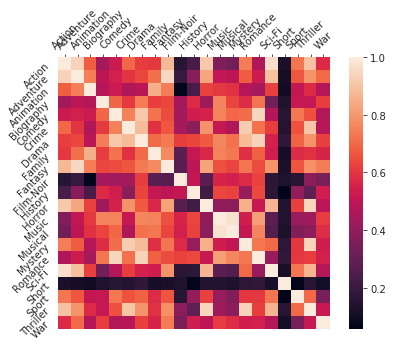

In [343]:
fig, ax = plt.subplots(1,1,figsize=[7,5])
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(genre_topic_vectors),
            ax = ax, xticklabels = genres, yticklabels = genres, square=True)
# ax.set(title = 'Topic similarity between genres')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
ax.set_yticklabels(ax.get_yticklabels(),rotation=45);
plt.savefig('/mnt/Genre_similarity.pdf',bbox_inches='tight')

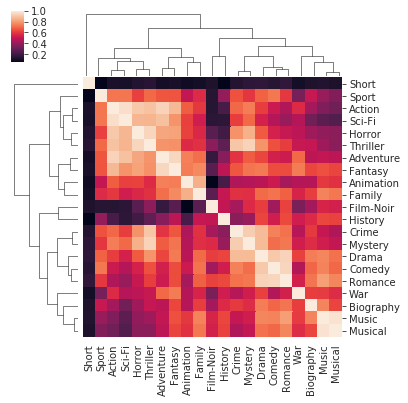

In [380]:
# fig, ax = plt.subplots(1,1,figsize=[7,5])
# sns.set_style('dark')
sns.clustermap(sklearn.metrics.pairwise.cosine_similarity(genre_topic_vectors), figsize = [6,6],
            xticklabels = genres, yticklabels = genres, square=True, method = 'complete')
plt.savefig('/mnt/Clustermap_genres.png',bbox_inches='tight', dpi = 400, transparent = True)

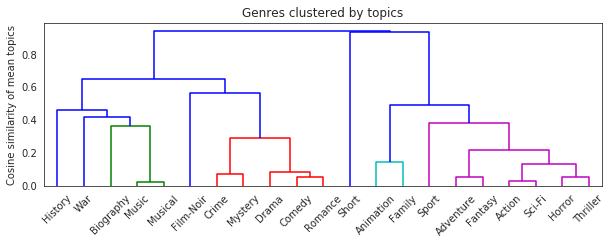

In [345]:
%matplotlib inline
sns.set_style('white')
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(genre_topic_vectors, method='complete',metric='cosine')
plt.figure(figsize=(10, 3))
dend = dendrogram(linked, labels=genres, color_threshold=0.4);
plt.title('Genres clustered by topics')
plt.ylabel('Cosine similarity of mean topics')
plt.savefig('/mnt/Dendrogram_genres.pdf',bbox_inches='tight')

## Compute similarity between movie script and review

In [660]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

In [102]:
# Load data with movie review IDs

In [699]:
reviews = pd.read_csv('../data/reviews_for_movs.csv', index_col=0)
reviews = reviews.loc[reviews['title'].isin(data['title'].unique()),:]
reviews = reviews.reset_index(drop=True)
reviews.head()

,review,title
0,"On his first day at a new school, Cameron fall...",10 Things I Hate About You
1,I wanted to see this movie when it first came ...,10 Things I Hate About You
2,"I have to say, I thoroughly enjoyed this movie...",10 Things I Hate About You
3,A movie like this doesn't exactly hit you over...,10 Things I Hate About You
4,I can't say enough good things about this movi...,10 Things I Hate About You


In [700]:
reviews['wiped_review'] = reviews['review'].apply(lambda x: cleanup_text(wipe_formatting(x)))

In [701]:
# reviews['topic_vector'] = reviews['wiped_review'].apply(lambda x: lda.transform(cv.transform([x]))[0])

In [702]:
cat_reviews = pd.DataFrame(reviews[['title','wiped_review']].groupby('title')['wiped_review'].apply(
    lambda x: ''.join(x)))

In [703]:
cat_reviews.head()

,wiped_review
title,
10 Things I Hate About You,on his first day at a new school cameron falls...
12 Years a Slave,twelve years a slave tells the true story of s...
12 and Holding,nice production good script outstanding castin...
127 Hours,despite having the opportunity to see darren a...
1492: Conquest of Paradise,the real story of columbus is an adventure sto...


In [704]:
cat_reviews['topic_vector'] = cat_reviews['wiped_review'].apply(lambda x: lda.transform(cv.transform([x]))[0])

In [706]:
review_topic_vectors = pd.DataFrame(cat_reviews['wiped_review'].apply(lambda x: lda.transform(cv.transform([x]))[0]))

In [740]:
review_topics_reformatted = pd.DataFrame(data=np.vstack(review_topic_vectors['wiped_review']), index=review_topic_vectors.index)

In [741]:
review_topics_reformatted.to_csv('../data/review_topic_vectors.csv')

In [743]:
movie_topics_reformatted = pd.DataFrame(data=np.vstack(data['topic_vector']), index=data.title)
movie_topics_reformatted.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.278357,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
12,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667
12 and Holding,0.052502,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.034678,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007
12 Monkeys,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.033248,...,0.000003,0.000003,0.000003,0.001367,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
12 Years a Slave,0.002355,0.002548,0.000003,0.015161,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.024342,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003


In [744]:
movie_topics_reformatted.to_csv('../data/movie_topic_vectors.csv')

In [645]:
cat_reviews.head()

,wiped_review,topic_vector
title,,
10 Things I Hate About You,on his first day at a new school cameron falls...,"[1.5082956259448215e-05, 1.5082956259448215e-0..."
12 Years a Slave,twelve years a slave tells the true story of s...,"[6.195786864941703e-06, 6.195786864941703e-06,..."
12 and Holding,nice production good script outstanding castin...,"[8.795074758148497e-06, 8.795074758148497e-06,..."
127 Hours,despite having the opportunity to see darren a...,"[7.262164124920959e-06, 7.262164124920959e-06,..."
1492: Conquest of Paradise,the real story of columbus is an adventure sto...,"[1.39470013947207e-05, 1.39470013947207e-05, 1..."


In [649]:
scripts_and_reviews = data[['title','topic_vector']].merge(cat_reviews, on='title',
                               suffixes = ['_script','_reviews']).reset_index()
scripts_and_reviews.head()

,index,title,topic_vector_script,wiped_review,topic_vector_reviews
0,0,10 Things I Hate About You,"[5.89448865311806e-06, 5.89448865311806e-06, 5...",on his first day at a new school cameron falls...,"[1.5082956259448215e-05, 1.5082956259448215e-0..."
1,1,12 and Holding,"[0.05250211640166881, 6.666666666675797e-06, 6...",nice production good script outstanding castin...,"[8.795074758148497e-06, 8.795074758148497e-06,..."
2,2,12 Years a Slave,"[0.002355039201095223, 0.002548143817454244, 2...",twelve years a slave tells the true story of s...,"[6.195786864941703e-06, 6.195786864941703e-06,..."
3,3,127 Hours,"[4.941932295534859e-06, 4.941932295534859e-06,...",despite having the opportunity to see darren a...,"[7.262164124920959e-06, 7.262164124920959e-06,..."
4,4,1492: Conquest of Paradise,"[4.042854255109809e-06, 4.042854255109809e-06,...",the real story of columbus is an adventure sto...,"[1.39470013947207e-05, 1.39470013947207e-05, 1..."


In [659]:
scripts_and_reviews.to_csv('../data/topics_in_scripts_and_reviews.csv')

In [650]:
sim_scripts_reviews = cos_sim(np.vstack(np.squeeze(scripts_and_reviews['topic_vector_script'].values)),
       np.vstack(np.squeeze(scripts_and_reviews['topic_vector_reviews'].values)))

##### Result: topic similarity between movies (Y axis) and review sets (X axis, i.e. the concatenated set of reviews for each movie)

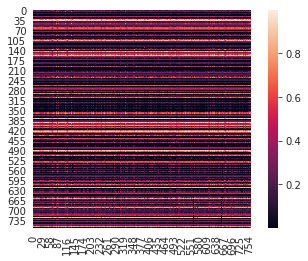

In [651]:
sns.heatmap(sim_scripts_reviews, square=True)

##### Why doesn't it work? Because all review sets are very similar – because they look like no movie at all!

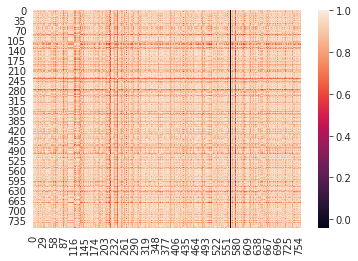

In [658]:
sns.heatmap(scipy.corrcoef(np.vstack(np.squeeze(scripts_and_reviews['topic_vector_reviews'].values))))